In [375]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

% LaTeX macros...
$\newcommand{\N}{\mathbb{N}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\P}{\mathcal{P}}$
$\newcommand{\U}{\mathcal{U}}$
$\newcommand{\bigO}{\mathcal{O}}$
$\newcommand{\dd}{\, \mathrm{d}}$
$\newcommand{\dt}[1]{\overset{\circ}{#1}}$
$\newcommand{\intset}[2]{\{#1, ..., #2\}}$

Notations:
- $\dt{x}$ is the derivative in time of x;
- if $x$ is a column vector, $x^T$ is the corresponding row vector;
- $A^T$ is the transpose of $A$. 

# Problem presentation and parameterization

Let's start with a very simple Linear Quadratic Control problem.

We study the movement of cart assimilated to a mechanical point of mass $m > 0$ that moves along an axis. Its position is denoted by $x \in \Omega = \R$. The cart starts from position $x_0 \in \Omega_0 = [-1, 0]$ and velocity $0$, and we want to bring the cart to position $0$ and keep it there as long as possible over a horizon $T$, with minimal control $u \in \R$. The control is here interpreted as a direct control of the velocity of the cart (and not of its acceleration).

In what follows we take $m=1$.

In [376]:
T = 1  # Time horizon for the control problem

## Formulation as a Continuous control problem

We denote by:
- $x: [0, T] \to \Omega$ the trajectory of the cart, that is its position at every time $t$;
- $u: [0, T] \to U$, where $U=\R$, the control overt time $t$. In what follows, we'll look for $u \in \U$ where $\U = L^1([0, T], U)$.

The dynamic of the system is given by the Cauchy problem:
$$
    \begin{cases}
        \dt{x}(t) = u(t) & \forall t \in [0, T],\\
        x(0) = x_0,
    \end{cases}
$$
where $x_0 \in [-1, 0]$.

Our choice of $\U$ ensures by Cauchy-Lipschitz theorem that this problem has a unique solution $x_u \in AC([0, T], \R)$.

We then want to minimize:
$$
    \min_{u \in \U} J(u),
$$
where
$$
    J(u) = \int_0^T \big( \lambda x(T)^2 + u(t)^2 \big) dt
$$
where $\lambda > 0$

In [377]:
LAMBDA = 10  # Null trajectory factor

This problem can be rewritten as a Linear Control Regulator (LQR):
$$
    \min_{u \in \U} J(u),
$$
where
$$
    J(u) = \int_0^T (x_u^T Q x_u + u^TRu) dt + x_u(T)^T D x_u(T)
$$
and
$$
    \begin{cases}
        \dt{x_u}(t) = Ax(t) + Bu(t) & \forall t \in [0, T],\\
        x(0) = x_0,
    \end{cases}
$$
where $A=0$, $B=1$, $Q=\lambda$, $R=1$ and $D=0$

## Remarks on the problem

This problem has several differences from the one tackled by Carlos Esteve in hiw work:
 - the problem is continuous both in time and space, so we will have to discretize it in time and (depending on the Q-learning algorithm we're using) in space;
 - the problem has a finite time-horizon T, and the optimal control at a given position in space depends on the remaining time before the horizon is reached: this makes the problem slightly more difficult and time should be part of the state of the system;
 - however, the reward can easily be defined at intermediary states, and not only at the final stage, which makes the learning process much easier (we can _almost_ just minimizing the current running cost!).

It also has some differences from RL for the control of Burgers:
 - We are not exactly trying to reach a target state _at_ a final time T here, but _over_ a time period $[0, T]$. The reason for this choice is that the optimal control would be a cosntant if we were trying to reach the target at time T, which is too simple.
 - The system is not governed by a PDE, but by a (simple) ODE. With a PDE, we might need another discretization in space to apply e.g. finite element methods (and we could make this discretization coincide with the one used to define Q as an array, see the implementation of the simple Q-learning method below). Our integrator would be more complicated than the one presented here.

# Utils

In [378]:
def plot_trajectory(predicted_x=None, gt_x=None, crop_y=False):
    """
    Plots the ground truth trajectory vs the predicted trajectory on a (t, x) plot.
    
    Parameters
    ----------
    predicted_x: None | np.array of floats
        Regularly spaced samples of the predicted trajectory. If None, this trajectory is not plotted.
    gt_x: None | np.array of floats
        Regularly spaced samples of the ground truth trajectory. If None, this trajectory is not plotted.
    crop_u: bool
        If True, crop the y axis to zoom on [-1, 0]
        
    Return
    ------
    None
    """
    plt.figure()
    if predicted_x is not None:
        t_prediction = np.linspace(0, T, predicted_x.shape[0])
        plt.plot(t_prediction, predicted_x, label="Prediction", color="tab:blue")
    if gt_x is not None:
        t_gt = np.linspace(0, T, gt_x.shape[0])
        plt.plot(t_gt, gt_x, label="Ground truth", color="tab:orange")
    if crop_y:
        plt.ylim([-1, 0])
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Trajectories")
    plt.legend()
    plt.grid()
    plt.show()

In [379]:
def plot_control(predicted_u=None, gt_u=None):
    """
    Plots the ground truth control vs the predicted control on a (t, u) plot.
    
    Parameters
    ----------
    predicted_u: None | np.array of floats
        Regularly spaced samples of the predicted control. If None, this control is not plotted.
    gt_u: None | np.array of floats
        Regularly spaced samples of the ground truth control. If None, this control is not plotted.
        
    Return
    ------
    None
    """
    plt.figure()
    if predicted_u is not None:
        t_prediction = np.linspace(0, T, predicted_u.shape[0])
        plt.scatter(t_prediction, predicted_u, label="Prediction", color="tab:blue", marker="x")
    if gt_u is not None:
        t_gt = np.linspace(0, T, gt_u.shape[0])
        plt.plot(t_gt, gt_u, label="Ground truth", color="tab:orange")
    plt.xlabel("t")
    plt.ylabel("u")
    plt.title("Controls")
    plt.legend()
    plt.grid()
    plt.show()

In [380]:
def plot_reward_trajectory(reward_trajectory):
    """
    Plots the reward at each time step on a (t, r) plot.
    
    Parameters
    ----------
    reward_trajectory: np.array of floats
        Reward collected at each time step.
        
    Return
    ------
    None
    """
    plt.figure()
    t = np.linspace(0, T, N+1)
    plt.plot(t, reward_trajectory)
    plt.xlabel("t")
    plt.ylabel("r")
    plt.title("Reward trajectory")
    plt.grid()
    plt.show()

In [381]:
def transform_interval(a, b, c, d, x):
    """
    Affine transformation that maps an interval [a, b] to an interval [c, d].
    
    Parameters
    ----------
    a: int
        Lower bound of the departure interval.
    b: int
        Upper bound of the departure interval.
    c: int
        Lower bound of the departure interval.
    d: int
        Upper bound of the departure interval.
    x: float
        The point to map from [a, b] to [c, d].
        
    Return
    ------
    The point of [c, d] that is the image of x by the affine transformation.
    """
    return (d-c)/(b-a)*x + (c*b-d*a)/(b-a)

In [382]:
def plot_loss_history(loss_history, evaluate_every=1, function_name="loss"):
    """
    Plots the loss history over episodes.
    
    Parameters
    ----------
    loss_history: np.array of floats
        The history of the loss.
    evaluate_every: int
        Number of training episodes ran between each evaluation. This is used to determine the correct scaling from the x axis.
    function_name: str
        Name of the loss function to display.
        
    Return
    ------
    None
    """
    plt.figure()
    plt.plot(np.arange(0, evaluate_every*len(loss_history), evaluate_every), loss_history)
    plt.title(f"History of the {function_name} during training")
    plt.xlabel("Episodes")
    plt.ylabel(function_name)
    plt.grid()
    plt.show()

In [383]:
def plot_reward_history(reward_history, evaluate_every=1, crop_reward=None):
    """
    Plots the reward_history history over episodes, with min, max and std.
    
    Parameters
    ----------
    reward_history: np.array of floats
        The history of the reward.
    evaluate_every: int
        Number of training episodes ran between each evaluation. This is used to determine the correct scaling from the x axis.
    crow_reward: None | tuple of ints
        The interval of reward values to show on the y axis. If None, scale automatically.
        
    Return
    ------
    None
    """
    plt.figure()
    episodes = np.arange(0, evaluate_every*len(reward_history), evaluate_every)
    reward_history = np.array(reward_history)
    plt.plot(episodes, reward_history.mean(axis=1), label="mean")
    plt.fill_between(episodes, reward_history.mean(axis=1) - reward_history.std(axis=1), reward_history.mean(axis=1) + reward_history.std(axis=1), alpha=0.4, label="std", color="gray")
    plt.fill_between(episodes, reward_history.min(axis=1), reward_history.max(axis=1), alpha=0.2, label="min-max", color="gray")
    plt.title("History of the reward during training")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    if crop_reward is not None:
        plt.ylim(crop_reward)
    plt.legend()
    plt.grid()
    plt.show()

# Continuous control implementation

Using the adjoint state $p$, we can get an analytical solution for the continuous control problem. Indeed, the control is optimal if and only if:
$$
    u(t) = -R^{-1}Bp(t) = -p(t) \qquad \forall t \in [0, T],
$$
where
$$
\begin{cases}
    \dt{p}(t) = -Ap(t) - Qx(t) = -\lambda x(t) & \forall t \in [0, T],\\
    p(T) = 0
\end{cases}
$$
Hence:
$$
\begin{cases}
    \dt{x} = u = p,\\
    \dt{p} = -\lambda x.
\end{cases}
$$
That is, for $X^T=(x\ p)$,
$$
    \dt{X} = Z X
$$
where
$$
    Z =\begin{pmatrix}
        0 & -1\\
        -\lambda & 0
    \end{pmatrix}.
$$
We thus know that:
$$
    X(t) = \begin{pmatrix} x_0 \\ p(0) \end{pmatrix} e^{tZ}.
$$
We compute by hand:
$$
    e^Z =\begin{pmatrix}
        \cosh(\sqrt{\lambda}) & -\frac{1}{\sqrt{\lambda}}\sinh(\sqrt{\lambda})\\
        -\sqrt{\lambda}\sinh(\sqrt{\lambda}) & \cosh(\sqrt{\lambda})
    \end{pmatrix}.
$$
and deduce:
$$
\begin{cases}
    x(t) = x_0\cosh(\sqrt{\lambda}t) - \frac{p(0)}{\sqrt{\lambda}}\sinh(\sqrt{\lambda}t),\\
    p(t) = -\sqrt{\lambda}x_0\sinh(\sqrt{\lambda}t) + p(0)\cosh(\sqrt{\lambda}t).
\end{cases}
$$
Lastly, using the fact that $p(T)=0$, we compute:
$$
\boxed{
\begin{cases}
    x(t) = \frac{x_0}{\cosh(\sqrt{\lambda}T)} \cosh\big(\sqrt{\lambda}(T-t)\big)\\
    u(t) = - p(t) = -\frac{\sqrt{\lambda}x_0}{\cosh(\sqrt{\lambda}T)}\sinh\big(\sqrt{\lambda}(T-t)\big)
\end{cases} \qquad \forall t \in [0, T].
}
$$

In [384]:
def ground_truth(x0, t):
    """
    Analytical expressions of the trajectory and the control for the continuous control problem.
    
    Parameters
    ----------
    x0: float in [-1, 0]
        Initial condition.
        
    Return
    ------
    A tuple of np.arrays (gt_x, gt_u) both of shape (res).
    """
    sqrtl = np.sqrt(LAMBDA)
    cosht = np.cosh(sqrtl*T)
    return (x0/cosht)*np.cosh(sqrtl*(T-t)), -(sqrtl*x0/cosht*np.sinh(sqrtl*(T-t)))

In [385]:
def ground_truth_sample(x0, res=10000):
    """
    Sample of the trajectory and control solution to the continuous control problem.
    
    Parameters
    ----------
    x0: float in [-1, 0]
        Initial condition.
    res: int
        Number of points to sample.
        
    Return
    ------
    A tuple of np.arrays (gt_x, gt_u) both of shape (res).
    """
    t = np.linspace(0, T, res)
    return ground_truth(x0, t)

In [386]:
def cost(x, u):
    """
    Compute an approximation of the cost function evaluated in a given trajectory-control pair (x, u), using trapezoidal rule.
    
    Parameters
    ----------
    x: np.array of floats
        The trajectory.
    u: np.array of floats
        The control.
            
    Return
    ------
    Approximation of the cost.
    """
    return LAMBDA*np.trapz(x**2, dx=T/x.shape[0]) + np.trapz(u**2, dx=T/u.shape[0])

## Visualization of the solution

In [387]:
x0 = -1
gt_x, gt_u = ground_truth_sample(x0)
print("Position at final time:", gt_x[-1])

Position at final time: -0.08450702270392474


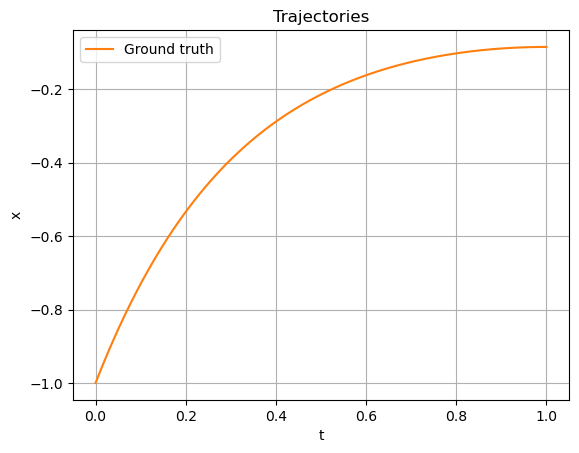

In [388]:
plot_trajectory(gt_x=gt_x, crop_y=False)

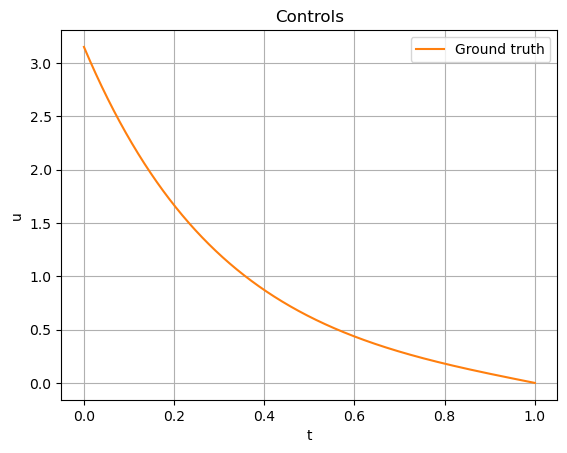

In [389]:
plot_control(gt_u=gt_u)

In [390]:
# Approximation of the optimal cost
cost(*ground_truth_sample(x0))

3.150650833590185

# Reinforcement Learning implementation

To make the problem solvable by RL using Q-learning methods (discrete and deep), we need to discretize it in time. Let $N \in \N^*$ be the discretization resolution and $\Delta t = \frac{T}{N} = \frac{1}{N}$ the time step. Let $\forall n \in \intset{0}{N}, \ t_n = n \Delta t, \ u_n = u(t_n)$ and $x_n = x(t_n)$.

With this discretization, we now _choose_ to restrict the search of a control $u$ in a subset $\U_{\Delta t} \subset \U$, namely:
$$
    \U_{\Delta t} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in U \right\}.
$$
This means that we can only hope to get a _suboptimal_ solution for the continuous control problem.

Moreover, we observe that for any $u \in \U_{\Delta t}$ and any $n \in \intset{1}{N}$:
$$
    x_{n+1} = x_n + \int_{t_n}^{t_{n+1}} \dt{x}(t) \dd t = x_n + \int_{t_n}^{t_{n+1}} u_n \dd t = x_n + \Delta t\,u_n,
$$
which encourages us to choose the following simulator that we will call every $\Delta t$ time step to compute the trajectory on points $x_n, \ n \in \intset{0}{N}$:
$$
\P: \begin{align}
    & \Omega \times U \to \Omega \\
    & (x, u) \mapsto x +\Delta t\, u.
\end{align}
$$
Note that this simulator is equivalent to using an _Euler explicit_ integration scheme but it computes the _exact_ value of $x_{n+1}$. This is because in our dynamics, $A=0$ and because we chose a convenient shape for $u$. For harder problems, we might want to use a numerical integration method which won't give the exact trajectory.

In this framing, the cost function _rewrites_:
$$
    J(u) = \lambda \int_0^T x(t)^2 \dd t + \Delta t \sum_{n=0}^{N-1} u_n^2 = \lambda \sum_{n=0}^{N-1} \int_{t_n}^{t_{n+1}} x(t)^2 \dd t + \Delta t \sum_{n=0}^{N-1} u_n^2
$$
Now, $\forall n \in \intset{0}{N-1}, \ \forall t \in [t_n, t_{n+1}], \ x(t) = x_n + (t-t_n)u_n$, so:
$$
    \int_{t_n}^{t_{n+1}} x(t)^2 \dd t = \Delta t x_n^2 + {\Delta t}^2 x_n u_n + \frac{{\Delta t}^3}{3} u_n^2
$$
So,
$$
    J(u) = \lambda \sum_{n=0}^{N-1} \Big( \Delta t x_n^2 + {\Delta t}^2 x_n u_n + \frac{{\Delta t}^3}{3} u_n^2 \Big) + \Delta t \sum_{n=0}^{N-1} u_n^2
$$
Note that here, the cost is still exactly equal to the one of the initial problem, because integrating $x^2$ on each segment $[t_n, t_{n+1}]$ is not difficult. Therefore, we will be able to design very accurate reward functions, that give a lot of information on the underlying model. In many cases, designing the reward after discretization of the temporal problem might not be that easy, leading to sub-optimal controls.

In [391]:
N = 20  # Number of time steps
DT = 1/N  # Time step

## Discrete Q-learning

### Discretization

In a first RL approach, let's use the $Q$-learning algorithm with an $\varepsilon$-policy, implementing $Q$ as a matrix such that $Q_{s, a}$ is an approximation of the $Q$ function in state $s$ and action $a$.

However, this implementation requires further discretizing the problem, both in state and action spaces.
Therefore, we arbitrarily restrain $U$ to $\tilde{U} = [U_l, U_r]$ (with $U_r \in \mathbb{Z}^-$ and $U_l \in \N$) and $\U$ to $\tilde{\U} = L^1\big( [0, T],  \tilde{U} \big)$. We also restrain $\Omega$ to $\tilde{\Omega} = [-\Omega_l, \Omega_r] = [-1 + U_l\,T, U_r\,T]$ which is a natural choice because it is the union of the sets $E(x_0, T) = \{x_1 \in \R | \exists u \in \tilde{\U}, \ x_u(T) = x_1 \} $ of reachable positions from $x_0$ and $T$, for $x_0 \in [-1, 0]$.

Let's introduce $N_\Omega$ and $N_U$ the discretization resolutions for $\tilde{\Omega}$ and $\tilde{U}$, and $\Delta x = \frac{1}{N_{\Omega}}$ and $\Delta u = \frac{1}{N_U}$. For consistency, if we want the minimal gap between 2 states to coincide with the minimal possible step taken by the system, we should choose $N_\Omega$ such that $\Delta x = \Delta u\,\Delta t$, that is $N_\Omega = \frac{N_U}{\Delta t}$.

We now look for $u$ in
$$
    \tilde{\U}_{\Delta t, \Delta u} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in \tilde{U}_{\Delta u} \right\},
$$
where
$$
    \tilde{U}_{\Delta u} = \{U_l, U_l + \Delta u, ..., U_r\}
$$
(so $|\tilde{U}_{\Delta u}| = (U_r - U_l)N_U + 1$).
Note that this will further increase the suboptimality of the solution we can expect to find.

Furthermore, for a correctly truncated $x_0$, with our choice of $\tilde{\U}_{\Delta t, \Delta u}$, the $x_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\Omega}_{\Delta x} = \{ \Omega_l, \Omega_l + \Delta u\,\Delta t, ..., \Omega_r \}
$$
(so $|\tilde{\Omega}_{\Delta x}| = (\Omega_r - \Omega_l)N_\Omega + 1$), which is consistent with our choice of $\Delta x$.

The minimization problem is now:
$$
    \min_{(u_n)_{n\in \{0, ..., N-1\}} \in (U_{\Delta u})^N} \lambda \sum_{n=0}^{N-1} \Big( \Delta t x_n^2 + {\Delta t}^2 x_n u_n + \frac{{\Delta t}^3}{3} u_n^2 \Big)+ \Delta t \sum_{n=0}^{N-1} u_n^2
$$

We are not done yet, because in practice $x$ and $u$ need to be integers if we want to interprete them as indices for $Q_{x, u}$ easily. The states and controls manipulated by $Q$ and the policy will live in:
$$
    \tilde{\Omega}_{\Delta x}^{RL} = \{ 0, \Delta x, ..., (\Omega_r - \Omega_l) N_\Omega \Delta x \}
$$
and
$$
    \tilde{U}_{\Delta u}^{RL} = \{ 0, \Delta u, ..., (U_r - U_l) N_U \Delta u \}
$$
respectively. We define functions to easily switch from one representation to another:
- $\phi_{u \to u^{Rl}}$ to go from $\tilde{U}_{\Delta u}$ to $\tilde{U}_{\Delta u}^{RL}$;
- $\phi_{x \to x^{RL}}$ to go from $\tilde{\Omega}_{\Delta x}$ to $\tilde{\Omega}_{\Delta x}^{RL}$

and their inverses $\phi_{u^{Rl} \to u}$ and $\phi_{x^{RL} \to x}$

In [392]:
# Discretization parameters
Ul = -4; Ur = 4  # Bounds between which we look for u
OMEGAl = -1 + Ul*T; OMEGAr = Ur*T  # Bounds between which lives x
N_U = 5  # Resolution of the discretization on u
Du = 1/N_U  # Disctretization step on u
N_OMEGA = int(N_U/DT)  #  Resolution of the discretization on x
Dx = 1/N_OMEGA  # Disctretization step on x
u_to_u_RL = lambda u: int(transform_interval(Ul, Ur, 0, (Ur-Ul)*N_U, u))  # This is to convert a control to an index for the np.array Q
u_RL_to_u = lambda u: transform_interval(0, (Ur-Ul)*N_U, Ul, Ur, u)  # Inverse of the previous 
x_to_x_RL = lambda x: int(transform_interval(OMEGAl, OMEGAr, 0, (OMEGAr-OMEGAl)*N_OMEGA, x))  # This is to convert a state to an index for the np.array Q
x_RL_to_x = lambda x: transform_interval(0, (OMEGAr-OMEGAl)*N_OMEGA, OMEGAl, OMEGAr, x)  # Inverse of the previous 

# Q-learning algorithm parameters
LEARNING_RATE = 0.2  # Default learning rate
EPSILON = 0.2  # Default epsilon for the u-epsilon policy
N_EPSISODES = 100  # Default number of episodes for training

In [393]:
u_to_u_RL = lambda u: round(transform_interval(Ul, Ur, 0, (Ur-Ul)*N_U, u))  # This is to convert a control to an index for the np.array Q
u_RL_to_u = lambda u: transform_interval(0, (Ur-Ul)*N_U, Ul, Ur, u)  # Inverse of the previous 
x_to_x_RL = lambda x: round(transform_interval(OMEGAl, OMEGAr, 0, (OMEGAr-OMEGAl)*N_OMEGA, x))  # This is to convert a state to an index for the np.array Q
x_RL_to_x = lambda x: transform_interval(0, (OMEGAr-OMEGAl)*N_OMEGA, OMEGAl, OMEGAr, x)  # Inverse of the previous 

### Formulation

We have the following formulation in RL:
- state space: $S = \tilde{\Omega}_{\Delta x}^{RL}$;
- a state is $s \in S$ and is the position of the cart at a given time step;
- action space $A = \tilde{U}_{\Delta u}^{RL} $;
- an action is $a \in A$ and is a representation of the control $u$ at a given time step;
- transition function: $f: S \times A \to S$ defined by $f(s, a) = \phi_{x \to x^{Rl}}\Big(\P\big(\phi_{x^{RL} \to x}(s), \phi_{u^{RL} \to u}(a)\big)\Big)$
- running reward function: $\forall n \in \intset{0}{N-1}, \ r_n(s, a) \equiv r(s, a) = -\lambda \Big( \Delta t |\phi_{x^{RL} \to x}(s)|^2 + {\Delta t}^2 \phi_{x^{RL} \to x}(s)\phi_{u^{RL} \to u}(a) + \frac{{\Delta t}^3}{3} |\phi_{u^{RL} \to u}(a)|^2 \Big) - \Delta t |\phi_{u^{RL} \to u}(a)|^2$
- final reward function: $r_N(s) = 0$

Note that since the problem is of finite time-horizon, it can't be stationary, so the $Q$ function and the policy $\pi$ will also depend on time.

### Implementation

In [394]:
def  running_reward(sn, an):
    """
    Takes state and action (s_n, a_n) and returns the associated running reward.
    
    Parameters
    ----------
    sn: int
        State at time t_n, represented as an index for Q.
    an: int
        State at time t_n, represented as an index for Q.
        
    Return
    ------
    Running reward r_n.
    """
    xn = x_RL_to_x(sn)
    un = u_RL_to_u(an)
    return -LAMBDA*(DT*xn**2 + DT**2*xn*un + (DT**3)/3*un**2) - DT*un**2

def  final_reward(sN):
    """
    Takes state and action (s_N) and returns the associated final reward.
    
    Parameters
    ----------
    sN: int
        State at time T, represented as an index for Q.
        
    Return
    ------
    Final reward r_f.
    """
    return 0

In [395]:
def  transition(sn, an):
    """
    Takes state and action (s_n, a_n) and return a new state s_{n+1} and reward r_n.
    
    Parameters
    ----------
    sn: int
        State at time t_n, represented as an index for Q.
    an: int
        State at time t_n, represented as an index for Q.
        
    Return
    ------
    The new state s_{n+1} and the reward r_n.
    """
    return (x_to_x_RL(x_RL_to_x(sn) + DT*u_RL_to_u(an)), running_reward(sn, an))

In [396]:
def piece_wise_cosntant_u_sample(u, res=10000):
    """
    Takes the sample of a control u and returns a new sample of different resolution, interpolating u as a piece-wise constant function.
    
    Parameters
    ----------
    u: np.array of float
        Sample of a control function u.
    res: int
        New resolution with which to sample u.
        
    Return
    ------
    New sample of piece-wise cosntant u.
    """
    new_u_indices = np.arange(res)
    return u[np.floor(u.shape[0]/res*new_u_indices).astype(int)]

def piece_wise_constant_u_cost(x, u, res=10000):
    """
    Compute an approximation of the cost function evaluated in a given trajectory-control pair (x, u) with u piece-wise constant, using trapezoidal rule. u is interpolated as a piece-wise constant function and sampled using resolution `res`.
    
    Parameters
    ----------
    x: np.array of floats
        The trajectory.
    u: np.array of floats
        The control, considered constant between samples.
    res: int
        New resolution with which to sample u.
            
    Return
    ------
    Approximation of the cost.
    """
    new_u = piece_wise_cosntant_u_sample(u, res=res)
    return cost(x, new_u)

In [397]:
def simulator(x0, policy):
    """
    Run a simulation of the system between times 0 and T.
    
    Parameters
    ----------
    x0: float in [0, 1]
        State at time 0.
    policy: function from S to A
        Function that given a state returns an action.
    
    Return
    ------
    The triplet (x, u, r) where x is the resulting trajectory, u the control and r the reward history, which are 3 np.arrays of size (N+1).
    """
    x = np.zeros(N+1)
    u = np.zeros(N+1)
    r = np.zeros(N+1)
    x[0] = x0
    for n in range(N):
        sn = x_to_x_RL(x[n])
        an = policy(n, sn)
        u[n] = u_RL_to_u(an)
        snew, r[n] = transition(sn, an)
        x[n+1] = x_RL_to_x(snew)
    r[-1] = final_reward(x[-1])
    u[-1] = 0  # u is given a shape N+1 to have matching shapes for x and u, which makes comparing with ground truth easier.
    return (x, u, r)

In [398]:
@dataclass
class TrainingHistory:
    evaluate_every: int
    nb_episodes_for_evaluation: int
    avg_cost: list
    cumulative_rewards: list

        
class Agent:
    def __init__(self, lr = LEARNING_RATE, eps = EPSILON, evaluate_every=500, nb_episodes_for_evaluation=100):
        self.Q = -max(LAMBDA, 1) * np.random.rand(N, (OMEGAr - OMEGAl)*N_OMEGA+1, (Ur - Ul)*N_U+1)  # Initialize Q randomly in an order of magnitude of the running cost
        self.lr = lr
        self.eps = eps
        self.training_history = TrainingHistory(evaluate_every, nb_episodes_for_evaluation, [], [])
        avg_cost, cumulative_rewards = self.evaluate()
        self.training_history.avg_cost.append(avg_cost)
        self.training_history.cumulative_rewards.append(cumulative_rewards)
    
    def policy(self, n, s):
        return np.argmax(self.Q[n, s, :])
    
    def Q_learn(self, n_episodes = 100000):
        evaluate_every = self.training_history.evaluate_every
        average_cost_over_episodes = []
        cumulative_rewards_over_episodes = []
        for k in range(n_episodes):
            x0 = -np.random.random()
            s = x_to_x_RL(x0)
            for n in range(N):
                if np.random.random() < self.eps:
                    eps_policy = lambda n, s: np.random.randint((Ur - Ul)*N_U+1)
                else:
                    eps_policy = self.policy
                a = eps_policy(n, s)
                s_new, r = transition(s, a)
                if n == N-1:
                    self.Q[n, s, a] = (1-self.lr)*self.Q[n, s, a] + self.lr*(r + final_reward(s_new))
                else:
                    self.Q[n, s, a] = (1-self.lr)*self.Q[n, s, a] + self.lr*(r + np.max(self.Q[n+1, s_new, :]))
                s = s_new
            if k % evaluate_every == 0:
                average_cost, cumulative_rewards = self.evaluate()
                average_cost_over_episodes.append(average_cost)
                cumulative_rewards_over_episodes.append(cumulative_rewards)
        self.training_history.avg_cost += average_cost_over_episodes
        self.training_history.cumulative_rewards += cumulative_rewards_over_episodes
    
    def evaluate(self):
        """ NB: this evaluation method gives more weight to instances with an initial state further from the target. """
        nb_episodes = self.training_history.nb_episodes_for_evaluation
        cumulative_cost = 0
        cumulative_rewards = np.zeros(nb_episodes)
        for e in range(nb_episodes):
            x0 = -np.random.random()
            s, a, r = simulator(x0, self.policy)
            cumulative_cost += piece_wise_constant_u_cost(s, a)
            cumulative_rewards[e] = np.sum(r)
        return cumulative_cost/nb_episodes, cumulative_rewards

### Test

#### Utilitary functions

The next function will allow us to visualize Q and interprete it.

In [399]:
def plot_Q(Q, n, state_zoom=None, colorbar_limits=None):
    """
    Plots the heatmap of the weights of Q (represented as a matrix) at time n*\Delta_t. Note that for convenience, Q is transposed for the representation.
    The x and y axes are scaled to represent the actions and states in U and \Omega, not U^{RL} and \Omega^{RL}.
    
    Parameters
    ----------
    Q: np.array of size (T, |OMEGA^RL|, |A|) with OMEGA^RL and A the spatial-state and action spaces
        The array representing the Q function.
    n: int
        The time step at which we represent Q.
    state_zoom: None | tuple(int, int)
        Interval of the state to show on the heatmap. If None, shows the entire state space.
    colorbar_limits: None | tuple(float, float)
        Limits for the colorbar: values of Q above these bounds will be truncated to the closest bound. If None, no limit is applied.
        
    Return
    ------
    None
    """
    Q = Q[n]
    state_zoom = state_zoom if state_zoom else (0, Q.shape[0]-1)
    colorbar_limits = colorbar_limits if colorbar_limits else (None, None)
    truncated_Q = Q[state_zoom[0]:state_zoom[1]+1, :]
    plt.figure()
    plt.imshow(np.transpose(truncated_Q), vmin=colorbar_limits[0], vmax=colorbar_limits[1])
    xticks = np.append(np.arange(0, truncated_Q.shape[0], truncated_Q.shape[0]//5), (x_to_x_RL(0)-state_zoom[0]))
    plt.xticks(ticks=xticks, labels=[f"{x:.2f}" for x in x_RL_to_x(np.arange(state_zoom[0], state_zoom[1]+1, truncated_Q.shape[0]//5))]+[0])
    yticks = np.array([0, u_to_u_RL(0), Q.shape[1]-1])
    plt.yticks(ticks=yticks, labels=[Ul, 0, Ur])
    plt.colorbar(location="bottom")
    plt.title(f"Q function at time step {n}")
    plt.xlabel("s")
    plt.ylabel("a")
    plt.show()

In [400]:
def test_agent(agent, x0=-1):
    """
    Plots the control predicted by the agent, the resulting trajectory and the trajectory of the reward for a given initial datum x_0. Print the resulting cost, as well as the optimal cost.
    
    Parameters
    ----------
    agent: Agent
        The agent to test.
    x0: float
        The initial condition to test with.
        
    Return
    ------
    None
    """
    gt_x, gt_u = ground_truth_sample(x0)
    predicted_x, predicted_u, reward_trajectory = simulator(x0, agent.policy)
    plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)
    plot_control(predicted_u=predicted_u, gt_u=gt_u)
    plot_reward_trajectory(reward_trajectory)
    print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u))
    print("Optimal cost:", cost(gt_x, gt_u))

#### Agent creation

Let's create an agent.

In [401]:
agent = Agent()

Predictions before any training:

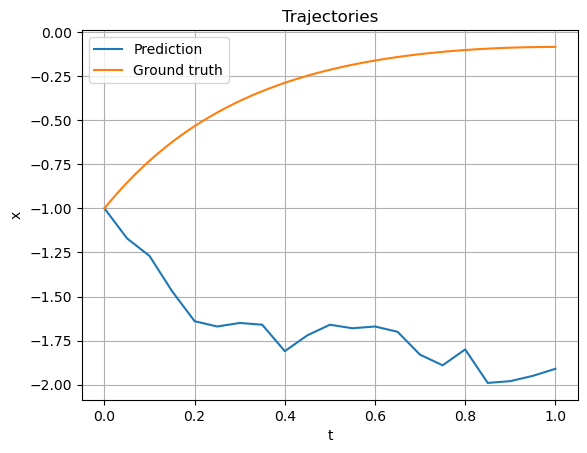

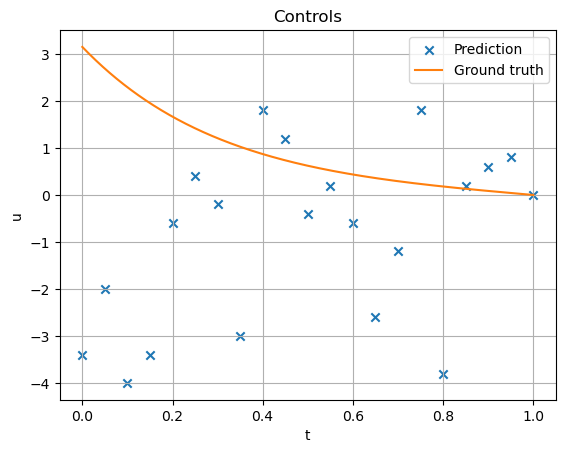

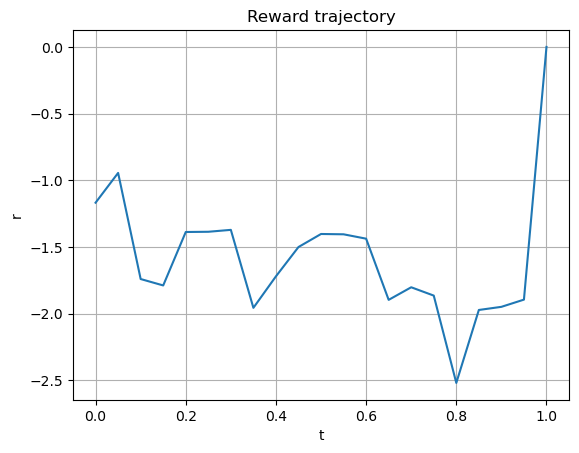

Cost for the predicted solution: 31.543484666666664
Optimal cost: 3.150650833590185


In [402]:
x0 = -1
test_agent(agent)

$\to$ The predictions are not good, which is normal because Q is initialized randomly. In the following cell, we plot $Q$ at different time steps ($0$, $\frac{N}{2} T$ and $N-1$). Note that the $s$ dimension for $Q$ is very large because it needs to encompass all reachable states for our choice of $U_{\Delta u}^{RL}$, so we are here zooming on the part of interest, that is in the neighborhood of $[-1, 0]$.

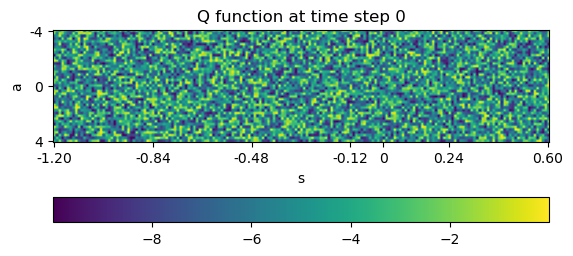

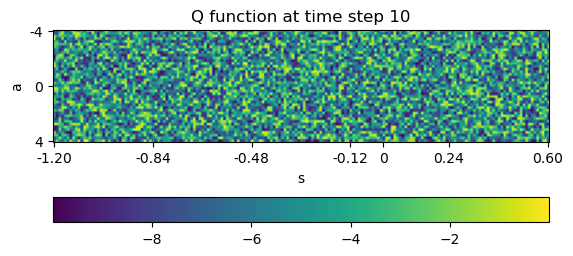

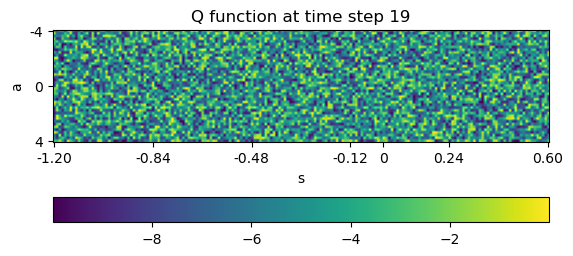

In [403]:
for n in [0, N//2, N-1]:
    plot_Q(agent.Q, n, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)))

### Training the agent

In [404]:
# This takes about 1min45 to run
agent.Q_learn(n_episodes=200000)

Predictions after training:

#### Results

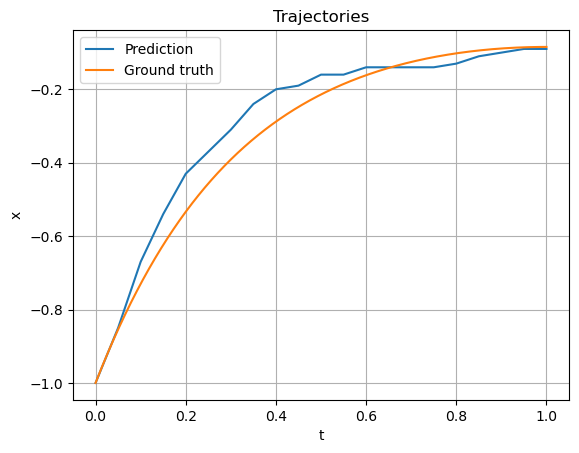

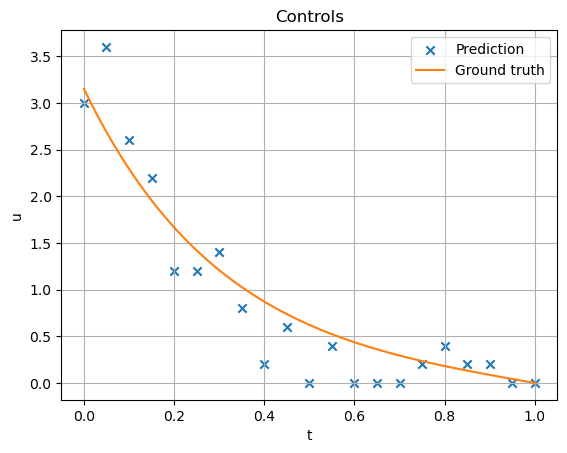

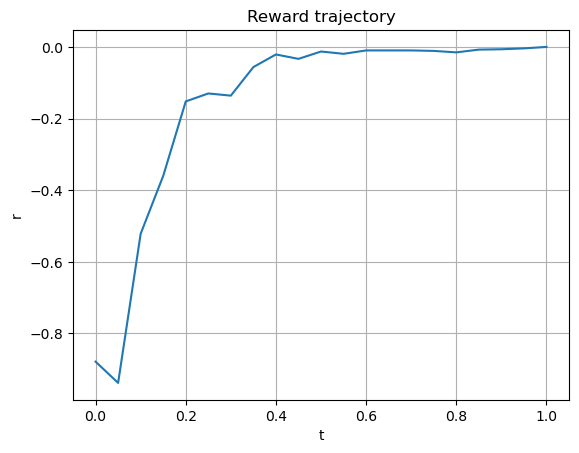

Cost for the predicted solution: 3.182386
Optimal cost: 3.150650833590185


In [405]:
test_agent(agent)

Much better! We see that the agent has learnt to solve the problem: the cost has gotten closer to the optimal and the predicted curves are closer to the ground truth. Still, it remains somewhat vertically shifted compared to the analytical solution, resulting from controls that are always a bit under-valued.

Let's visualize this learning by plotting the $Q$ function again (here we cut values below $-5$, $-4$ and $-3$ and $-2$ at the respective time steps $0$, $\frac{N}{3}$, $\frac{2N}{3}$ and $N-1$ for better visualization, because rewards-to-go diminish as time goes) :

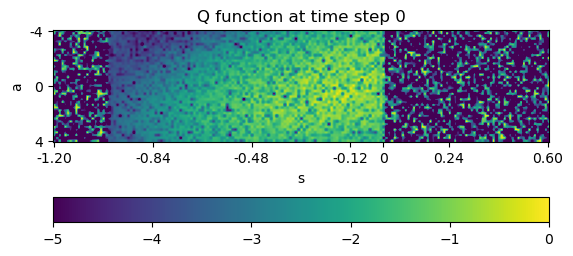

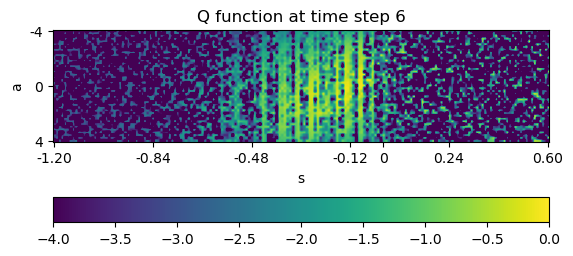

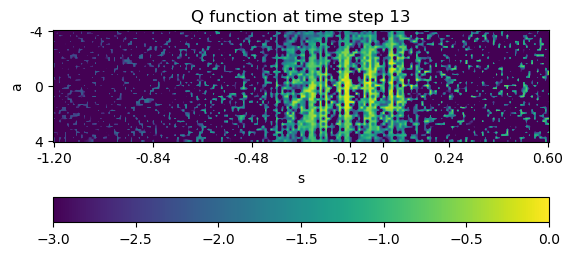

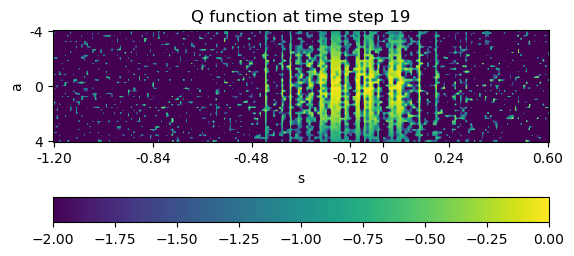

In [406]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-5, 0))
plot_Q(agent.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(agent.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))

The $Q$ function is not random anymore! Let's make some observations.
 - At time $0$, the agent has fully explored states in $[-1, 0]$: this is normal, as it just corresponds to our initialization of $x_0$ durng training episodes.
 - As time goes, the explored area shifts towards the target because as it explores, the agent learns to get closer to the target, and thus explores these closer areas...
 - We also see that values closer to $a=0$ have higher values, which maks sense because stronger controls have higher costs and risk overshooting.
 - For later time steps, the agent tends to overshoot the target.
 - For early time steps, the values tend to be higher for higher actions, while $Q$ is more symetrical for later time steps. 

Finally, let's plot the evolution of the average cost and the average cumulative reward as the agent has trained:

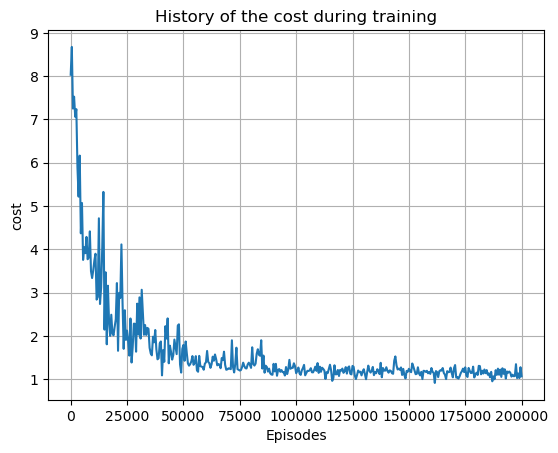

In [407]:
plot_loss_history(agent.training_history.avg_cost, agent.training_history.evaluate_every, function_name="cost")

We observe that the average cost (for $x_0$ chosen uniformly in $[-1, 0]$) is decreasing and coverges to $\approx 1.2$.

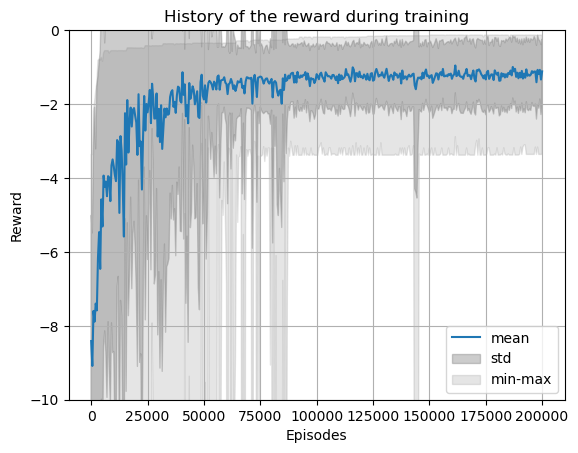

In [408]:
plot_reward_history(agent.training_history.cumulative_rewards, agent.training_history.evaluate_every, crop_reward=(-10, 0))

Unsurprisingly, it is the symetrical of the previous because of the way we designed our reward. Here, we also see that the standard deviation decreases with time, but also that it steeply drops around 50000 episodes, puzzlingly.

### Testing different initial conditions

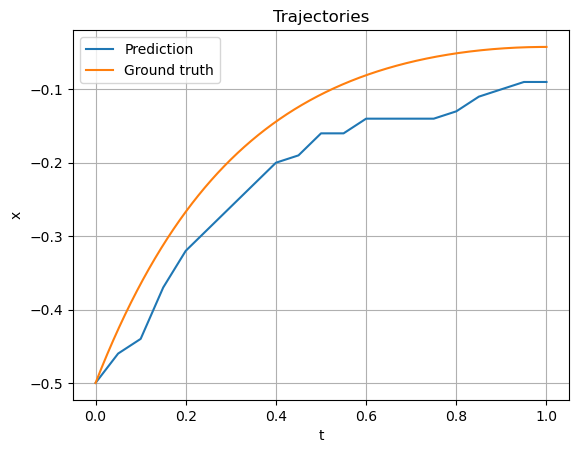

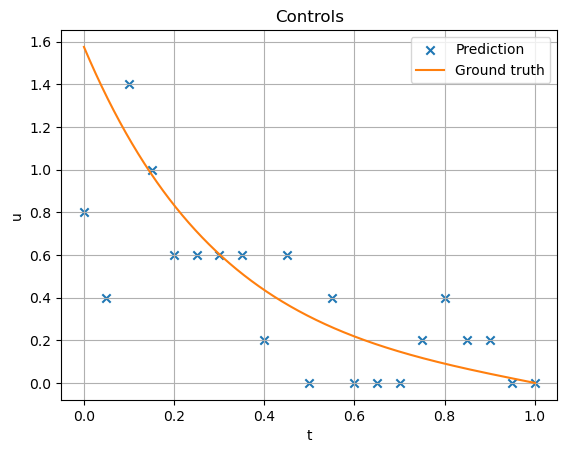

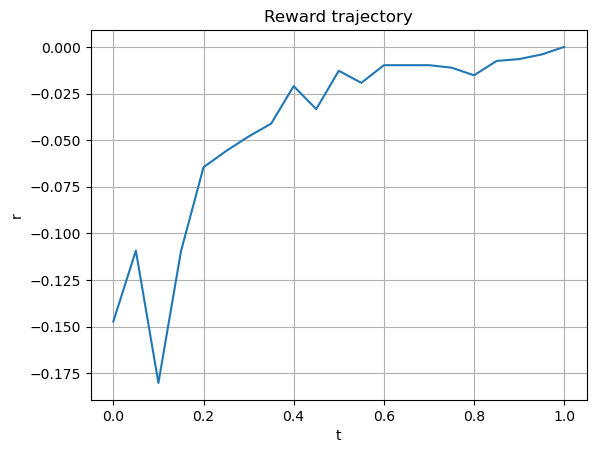

Cost for the predicted solution: 0.8737426666666666
Optimal cost: 0.7876627083975463


In [409]:
x0 = -0.5
test_agent(agent, x0)

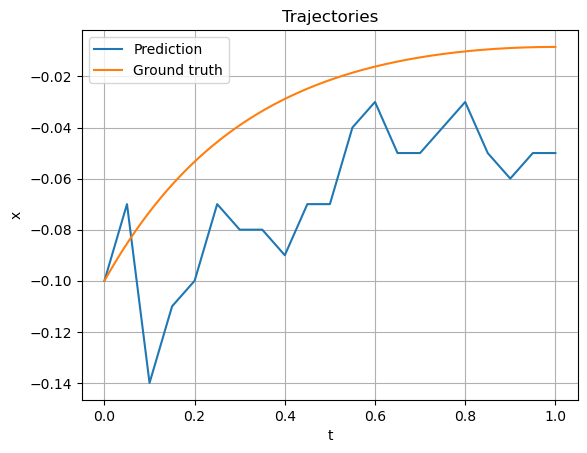

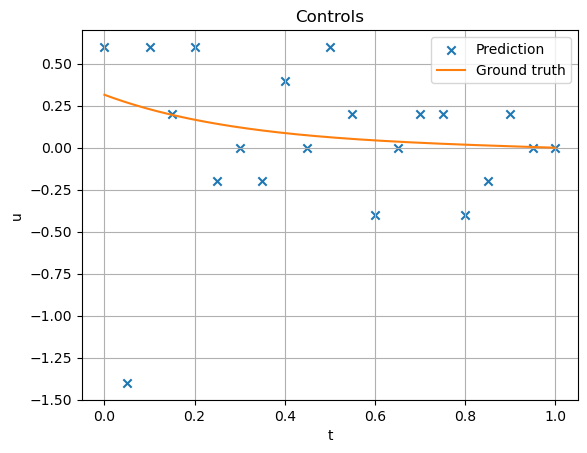

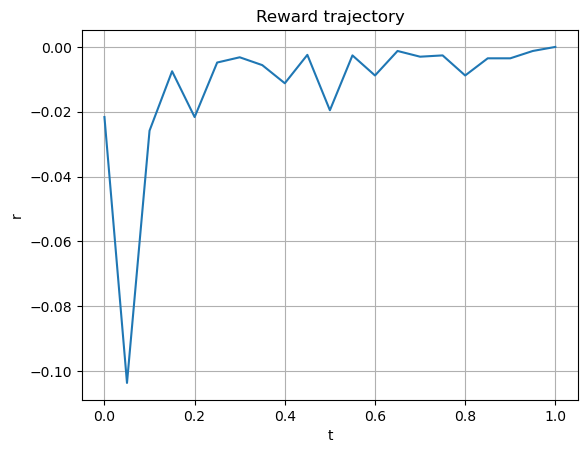

Cost for the predicted solution: 0.2509581904761906
Optimal cost: 0.03150650833590185


In [410]:
x0 = -0.1
test_agent(agent, x0)

The agent seems not to be as good for smaller $x_0$, which is counter intuitive as one could think that the agent has explored more close to the target.

### Twisting the parameters

#### Large $\varepsilon$

Let's choose a bigger $\varepsilon$ for the $\varepsilon$-policy: the exploration phase should be more pronouced, and the agent should have some difficulty converging, but might give better resuls.

In [447]:
agent = Agent(eps=0.8)

In [448]:
# The agent is much longer to train, this will take some time!
agent.Q_learn(n_episodes=400000)

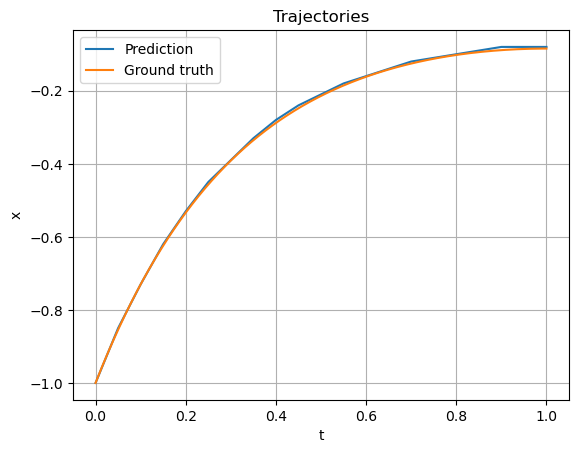

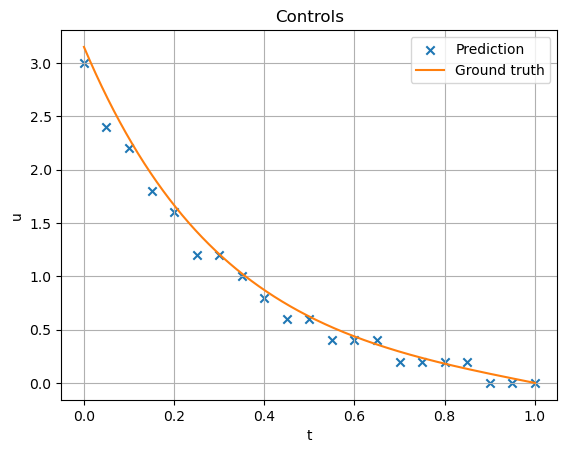

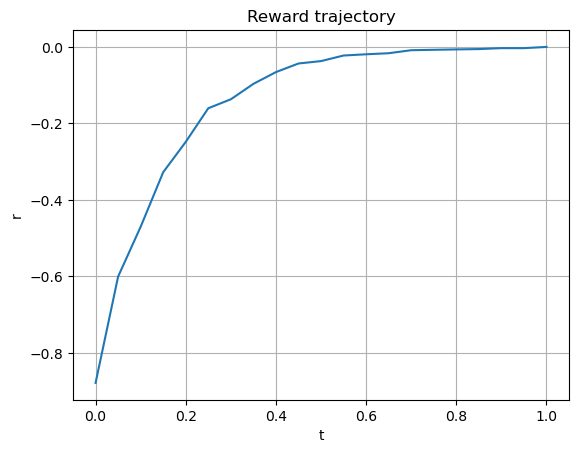

Cost for the predicted solution: 3.014562
Optimal cost: 3.150650833590185


In [449]:
test_agent(agent)

Wow! The solution is much closer to the analytical solution! With more exploration, the agent has been able to discover more interesting paths, resulting in better overall results.
Also, note that since we don't use the same precision on the trajectory for the prediction and the ground truth, we also don't compute the cost with the same precision, so we might see costs that are "better" than the optimal. 

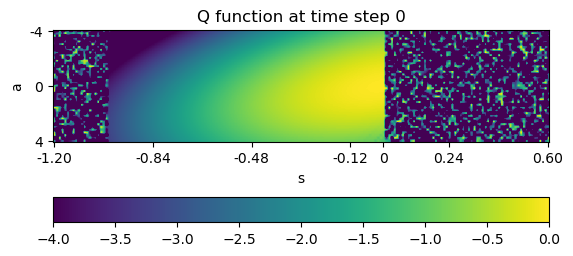

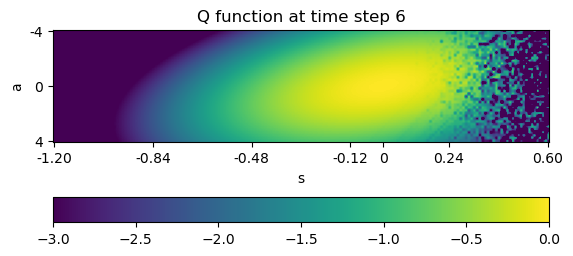

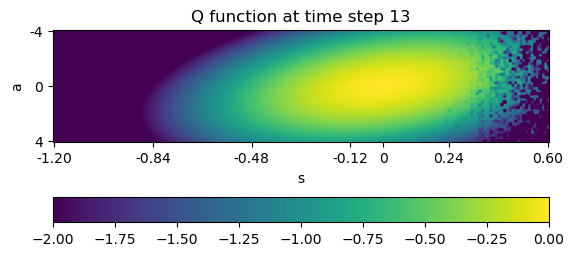

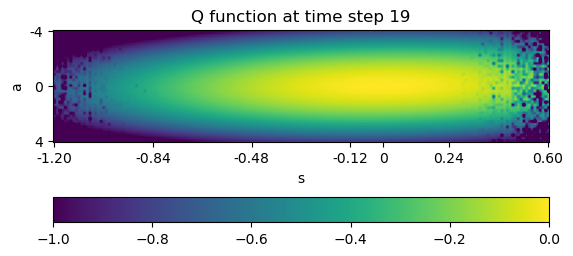

In [453]:
plot_Q(agent.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(agent.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(agent.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))
plot_Q(agent.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-1, 0))

The $Q$ function is much smoother and more largely explored, because the random decisions taken by the agent during the training allows the system to go almost anywhere at any time! Observations and interpretation is made easier here. We find again most of our previous observations, but we also see that the iso-$Q$ curves at a given time form ellipses that are tilted from bottom-left to top-right. this makes sense, because you rarely have any good reason to go left, unless you have overshot. This tilting tends to disappear in favour of a more symmetrical (w.r.t. $a$) $Q$-function for later time steps. This is probably because doing bad moves at the last moment has less incidence on the overall cumulative reward, because there are no further time steps to possibly chain bad moves thereafter.

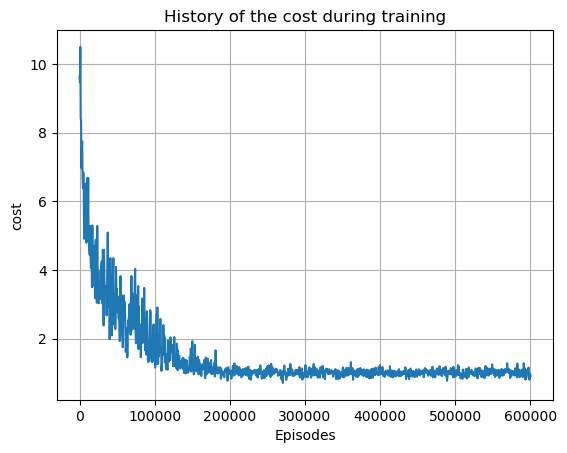

In [454]:
plot_loss_history(agent.training_history.avg_cost, agent.training_history.evaluate_every, function_name="cost")

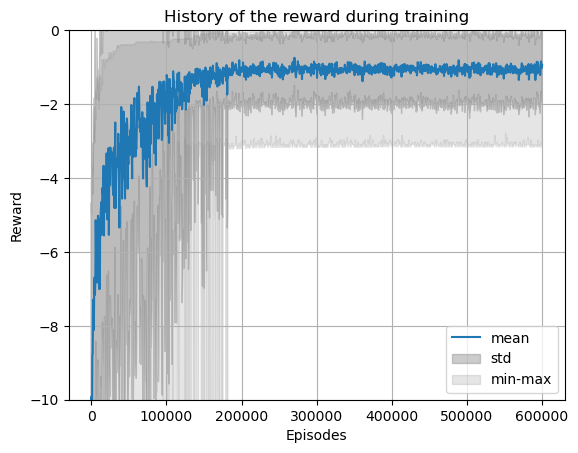

In [455]:
plot_reward_history(agent.training_history.cumulative_rewards, agent.training_history.evaluate_every, crop_reward=(-10, 0))

The agent took much more than twice as much time to converge. We still notice that the std drops steeply for some reason.

### Testing different initial conditions

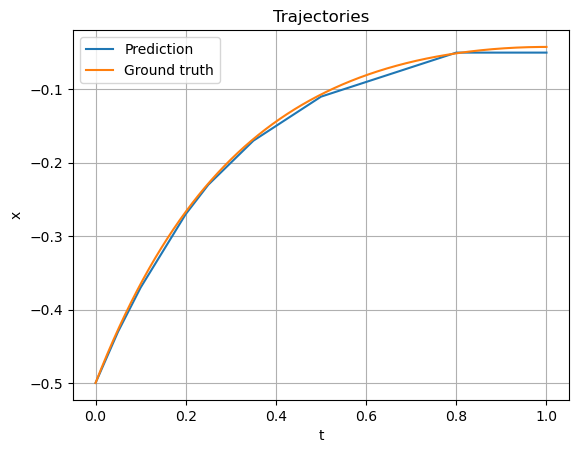

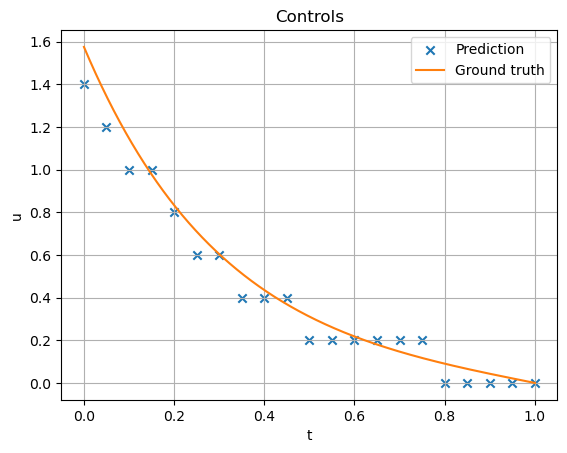

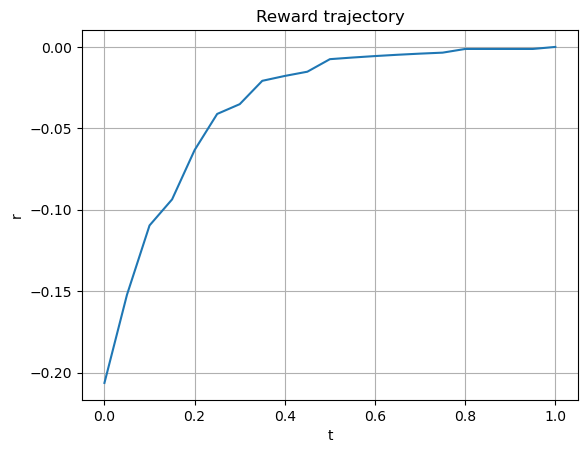

Cost for the predicted solution: 0.7560233333333332
Optimal cost: 0.7876627083975463


In [444]:
x0 = -0.5
test_agent(agent, x0)

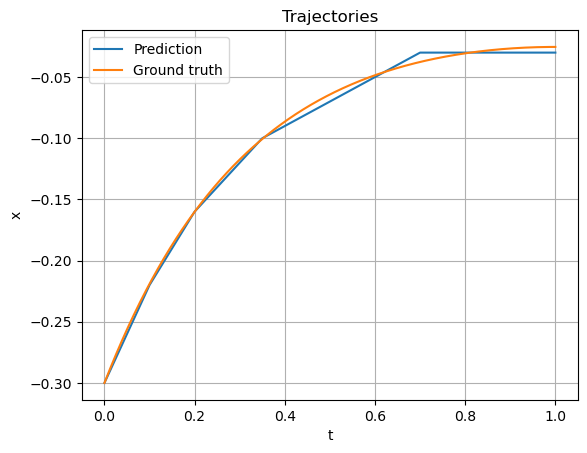

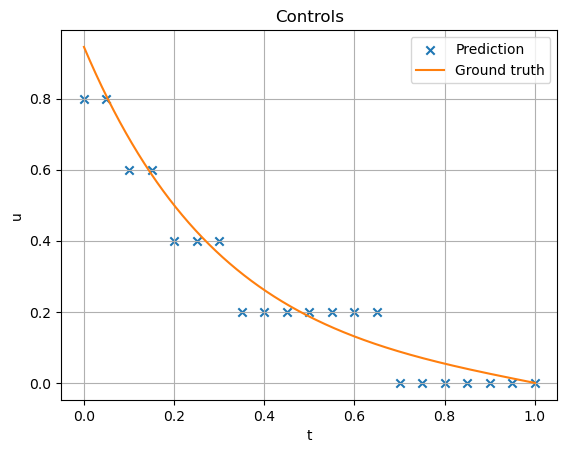

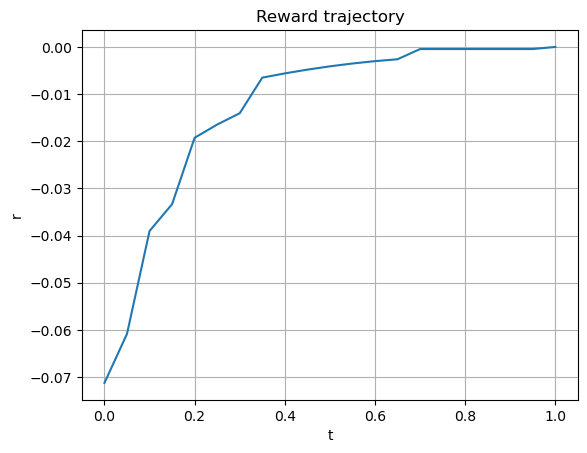

Cost for the predicted solution: 0.27411847619047625
Optimal cost: 0.2835585750231166


In [418]:
x0 = -0.3
test_agent(agent, x0)

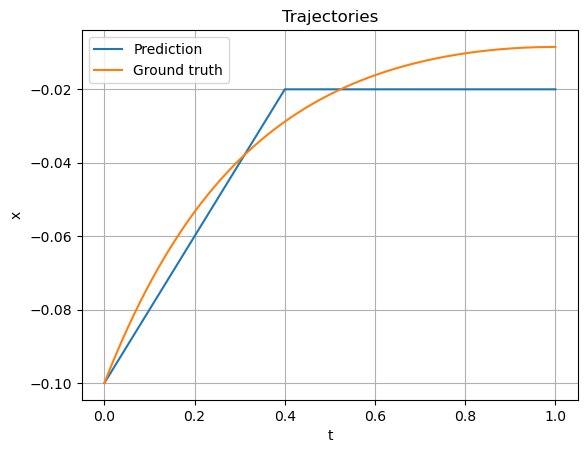

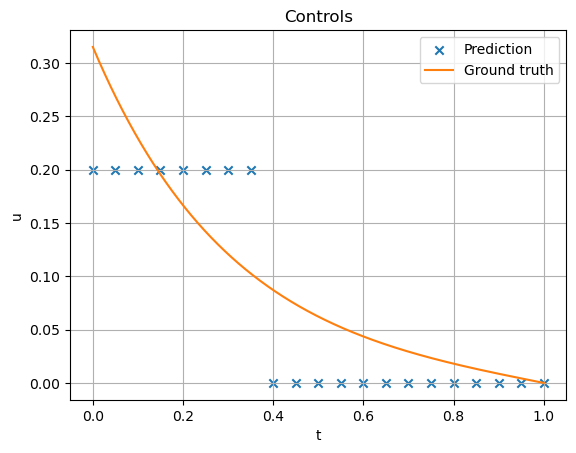

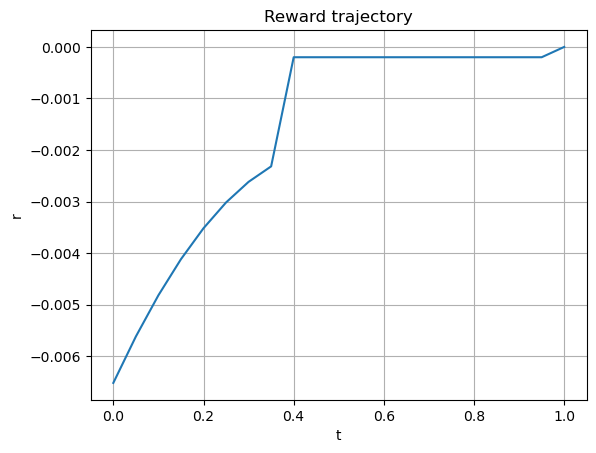

Cost for the predicted solution: 0.03333323809523801
Optimal cost: 0.03150650833590185


In [419]:
x0 = -0.1
test_agent(agent, x0)

The agent gives good results even for $x_0$ closer to the target. Also, for $x_0=-0.1$, the curve is a bit jagged, but that's probably due to our discretization.

#### Large learning rate

Finally, this time let's choose a bigger learning rate for the update of the $Q$ function. The learning procedure should converge faster, but might lead to results that are not as good.

In [420]:
agent_lr = Agent(lr=0.8)

In [421]:
agent_lr.Q_learn()

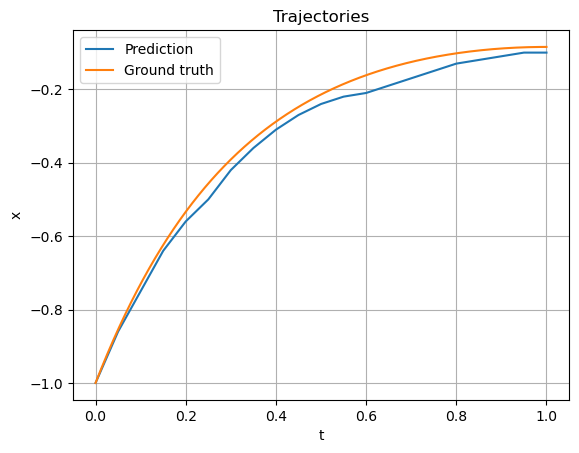

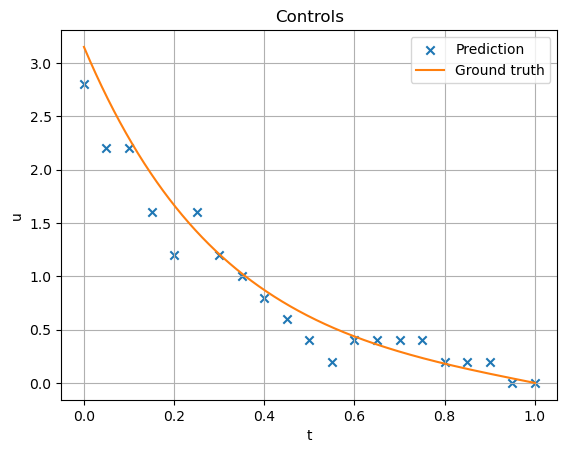

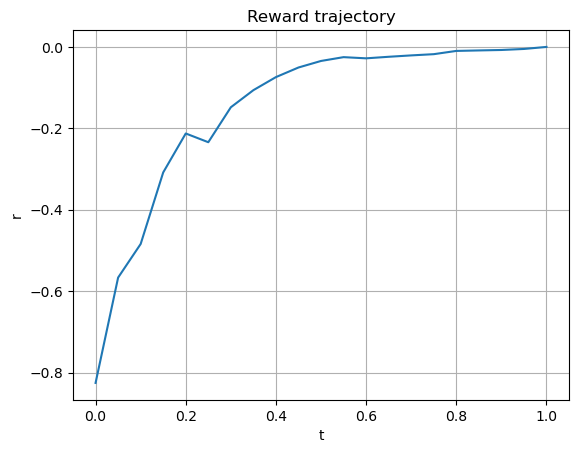

Cost for the predicted solution: 3.045042285714286
Optimal cost: 3.150650833590185


In [422]:
test_agent(agent_lr)

Surprisingly, the agent still performed better that we our initial parameters.

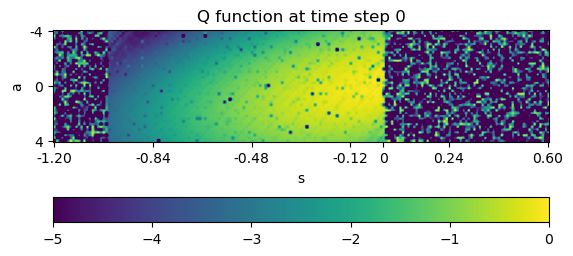

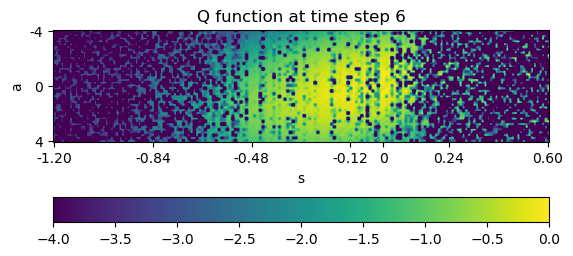

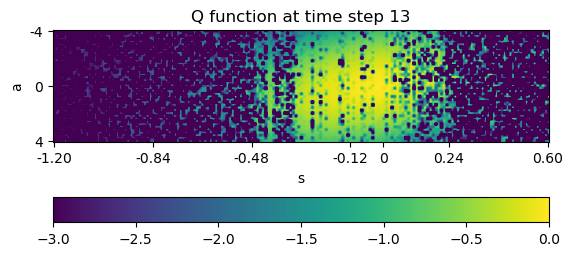

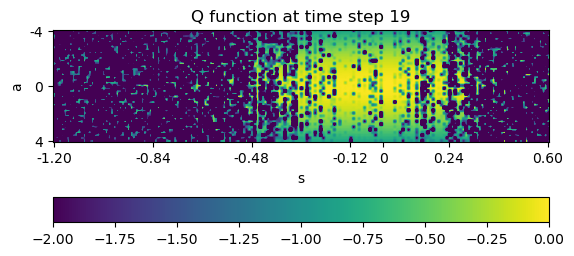

In [423]:
plot_Q(agent_lr.Q, 0, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-5, 0))
plot_Q(agent_lr.Q, N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-4, 0))
plot_Q(agent_lr.Q, 2*N//3, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-3, 0))
plot_Q(agent_lr.Q, N-1, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)), colorbar_limits=(-2, 0))

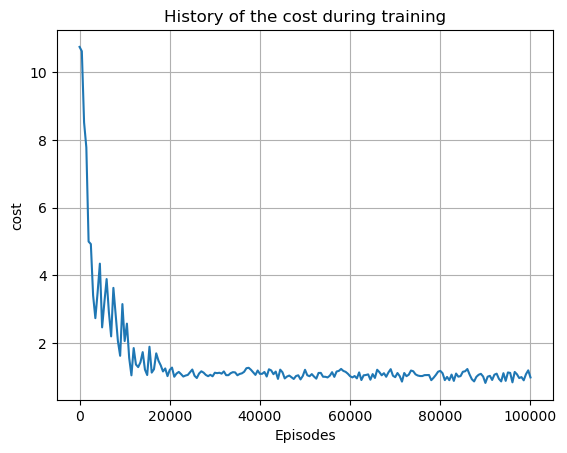

In [424]:
plot_loss_history(agent_lr.training_history.avg_cost, agent_lr.training_history.evaluate_every, function_name="cost")

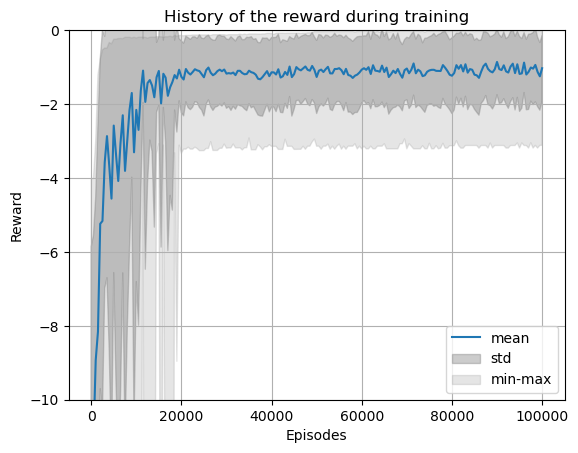

In [425]:
plot_reward_history(agent_lr.training_history.cumulative_rewards, agent_lr.training_history.evaluate_every, crop_reward=(-10, 0))

The agent converges much faster indeed!

#### Testing different initial conditions

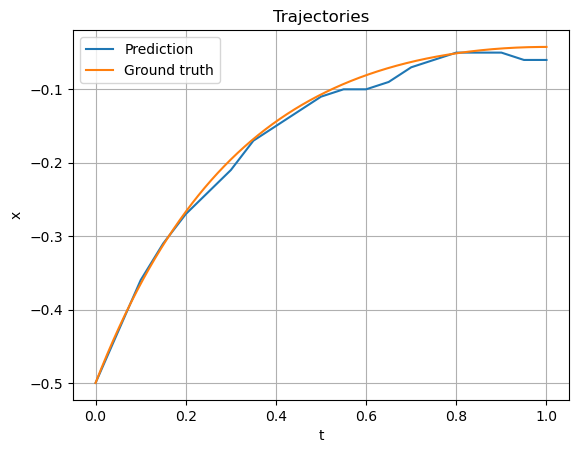

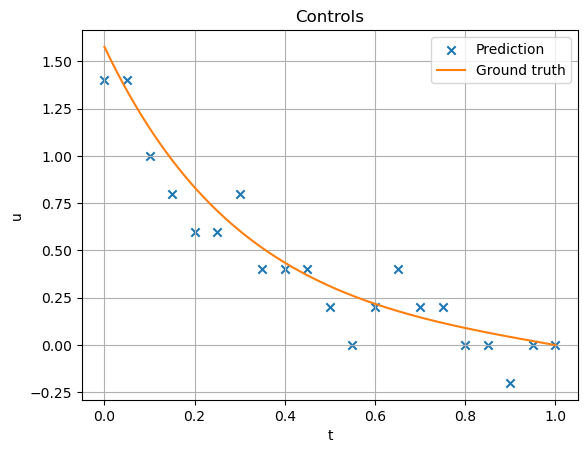

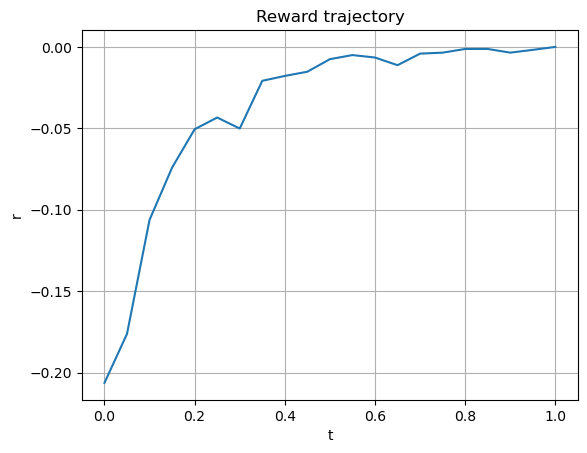

Cost for the predicted solution: 0.769565619047619
Optimal cost: 0.7876627083975463


In [426]:
x0 = -0.5
test_agent(agent_lr, x0)

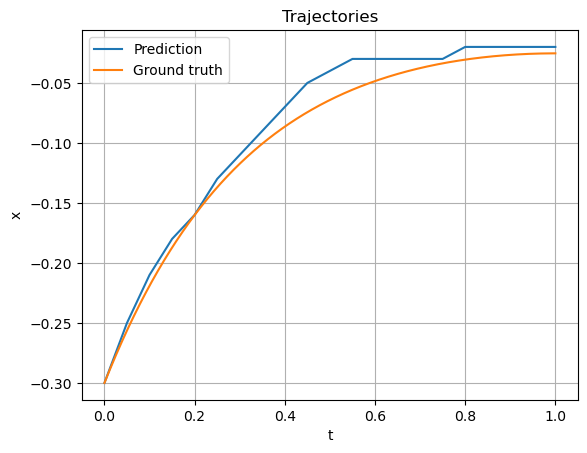

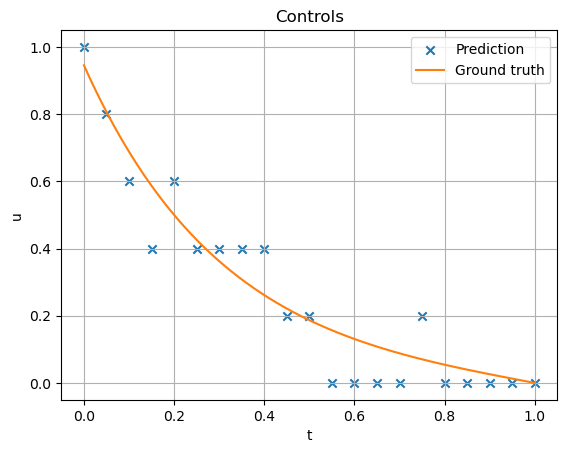

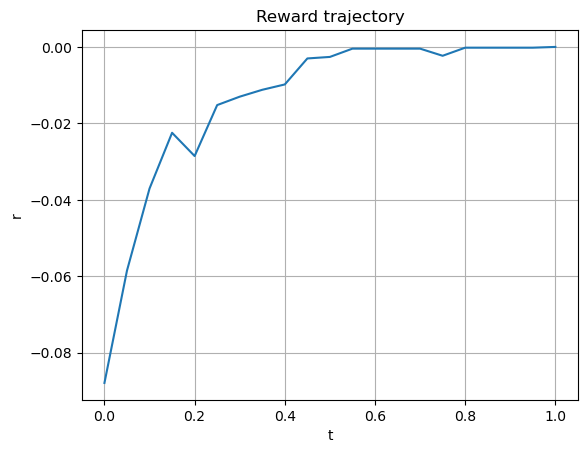

Cost for the predicted solution: 0.28096390476190497
Optimal cost: 0.2835585750231166


In [427]:
x0 = -0.3
test_agent(agent_lr, x0)

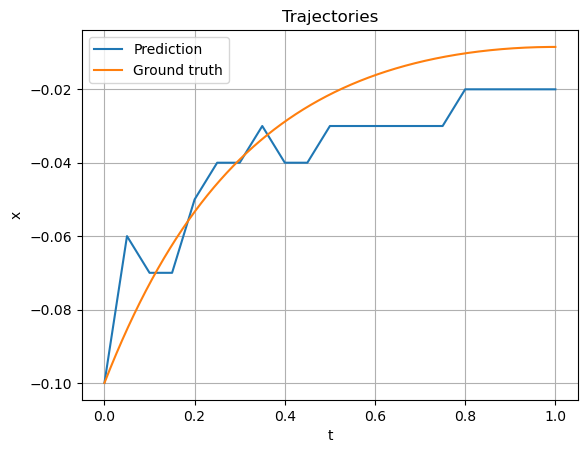

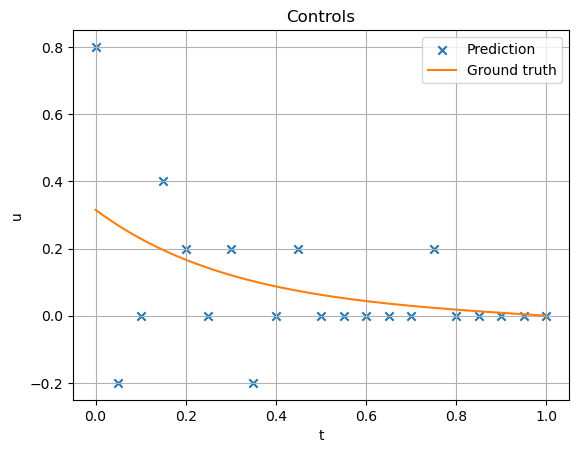

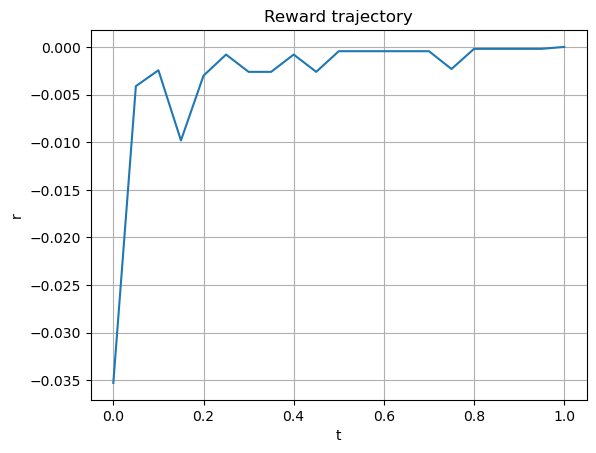

Cost for the predicted solution: 0.06639714285714296
Optimal cost: 0.03150650833590185


In [428]:
x0 = -0.1
test_agent(agent_lr, x0)

### Conclusion on vanilla Q-learning

We could still play with the parameters to try and get the best performance vs training-time compromise. From what we saw, using high learning rate seems to give good compromises if you want to learn quickly.

Let's make a comment on the sample efficiency here. If solved exactly with dynamic programming, our discretized problem would have a complexity of $\bigO(N\times|\Omega|\times|U|) = \bigO\big(N \times (\Omega_r - \Omega_l)N_{\Omega} \times (U_r - U_l)N_U\big)$. With our choice of parameters ($N=20$, $N_U=5$, $U_l=-4$ and $U_r=4$), this is proportional to $720\,000$ elementary operations (where an elementary operation is an either computing a transition (next state and running reward) or the access to a value in an array like $V$).

Now, putting aside monitoring operations, vanilla Q-learning does essentially 3 things at each time step of an episode: calling the optimal policy (that is, computing an argmax of $Q$ on the actions at fixed time and state), running a transition and updating $Q$. The last 2 operations are in $\bigO(1)$, but the fiest operation is in $\bigO(|U|)$ (in the worst case). So, denoting $\mathcal E$ the number of training episodes, that's a complexity in $\bigO(\mathcal E \times N \times |U|)$. Even in the case of a high learning rate (in which case the agent took, otpimitically, roughly $20\,000$ episodes to converge), that's proportional to $16\,000\,000$ elementary operations, that is about $22$ times more than with an optimal solving!

This illustrates that, although this RL method doesn't bother exploring all (state, action) pairs (as seen when looking at $Q$), it remains highly sample-inefficient. Many algorithms exist to try to make a better use of samples, for instance using deep reinforcement learning and replay buffers.

In the next section, we solve by DP to illustrate this.

## Dynamic programming

The formulation in DP is very close to that of RL:
- state space: $S = \tilde{\Omega}_{\Delta x}$;
- a state is $s \in S$ and is the position of the cart at a given time step;
- action space $A = \tilde{U}_{\Delta u} $;
- an action is $a \in A$ and is a representation of the control $u$ at a given time step;
- transition function: $f: S \times A \to S$ defined by $f(s, a) = \P\big(s, a\big)$
- running cost function: $\forall n \in \intset{0}{N-1}, \ c_n(s, a) \equiv c(s, a) = \lambda \Big( \Delta t\,s^2 + {\Delta t}^2\,s\,a + \frac{{\Delta t}^3}{3}a^2 \Big) + \Delta t\,a^2$
- final cost function: $c_N(s) = 0$

Here, $\forall s \in \tilde{\Omega}_{\Delta x}, \ V(N, x) = 0$ and the Bellman equation writes:
$$
    \forall n \in \intset{0}{N-1}, \ \forall s \in \tilde{\Omega}_{\Delta x}, \ V(n,x) = \min_{u \in \tilde{U}_\Delta u} \big(c(s, a) + V(n+1, \P(s, a)) \big)
$$

In [429]:
import math

def  running_cost(sn, an):
    return LAMBDA*(DT*sn**2 + DT**2*sn*an + (DT**3)/3*an**2) + DT*an**2

def  final_cost(sN):
    return 0

def  transition_DP(sn, an):
    return x_to_x_RL(sn + DT*an)

def reachable_s(n):
    """ Set of positions that are reachable in n time steps. """
    return np.arange(-1 + n*Ul*DT, n*Ur*DT+Dx/2, Dx)

In [430]:
# Solve by DP
action_space = np.arange(Ul, Ur+Du, Du)
V = np.inf*np.ones((N+1, (OMEGAr - OMEGAl)*N_OMEGA+1))
optimal_policy_array = np.ones((N, (OMEGAr - OMEGAl)*N_OMEGA+1))
for s in reachable_s(N):
    V[-1,x_to_x_RL(s)] = final_cost(s) 
for n in range(N-1, -1, -1):
    for s in reachable_s(n):
        costs = np.array([running_cost(s, a) for a in action_space])
        next_Vs = np.array([V[n+1, transition_DP(s, a)] for a in action_space])
        optimal_a = np.argmin(costs + next_Vs)
        V[n, x_to_x_RL(s)] = costs[optimal_a] + next_Vs[optimal_a]
        optimal_policy_array[n, x_to_x_RL(s)] = optimal_a
optimal_policy = lambda n,s: optimal_policy_array[n, s]

This only took a few seconds to run! Note that we are not exploring the entire state space here, but only those that are actually rechable at each time step starting in $[-1, 0]$ and using actions in $[-U_l, U_r]$. This further emphasizes the fact that the use of RL is not appropriate for such simple problems.

In [431]:
def plot_V(V, state_zoom=None, colorbar_limits=None):
    state_zoom = state_zoom if state_zoom else (0, V.shape[1]-1)
    colorbar_limits = colorbar_limits if colorbar_limits else (None, None)
    truncated_V = V[:,state_zoom[0]:state_zoom[1]+1]
    plt.figure()
    plt.imshow(truncated_V, vmin=colorbar_limits[0], vmax=colorbar_limits[1])
    xticks = np.append(np.arange(0, truncated_V.shape[1], truncated_V.shape[1]//5), (x_to_x_RL(0)-state_zoom[0]))
    plt.xticks(ticks=xticks, labels=[f"{x:.2f}" for x in x_RL_to_x(np.arange(state_zoom[0], state_zoom[1]+1, truncated_V.shape[1]//5))]+[0])
    plt.colorbar(location="bottom")
    plt.title("Value function")
    plt.xlabel("s")
    plt.ylabel("n")
    plt.show()

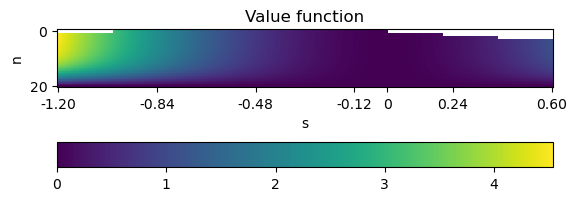

In [432]:
plot_V(V, state_zoom=(x_to_x_RL(-1.2), x_to_x_RL(0.6)))

In [433]:
def test_policy(policy, x0=-1):
    gt_x, gt_u = ground_truth_sample(x0, res=N)
    predicted_x, predicted_u, reward_trajectory = simulator(x0, policy)
    plot_trajectory(predicted_x=predicted_x, gt_x=gt_x)
    plot_control(predicted_u=predicted_u, gt_u=gt_u)
    plot_reward_trajectory(reward_trajectory)
    print("Cost for the predicted solution:", piece_wise_constant_u_cost(predicted_x, predicted_u))
    print("Optimal cost:", cost(gt_x, gt_u))

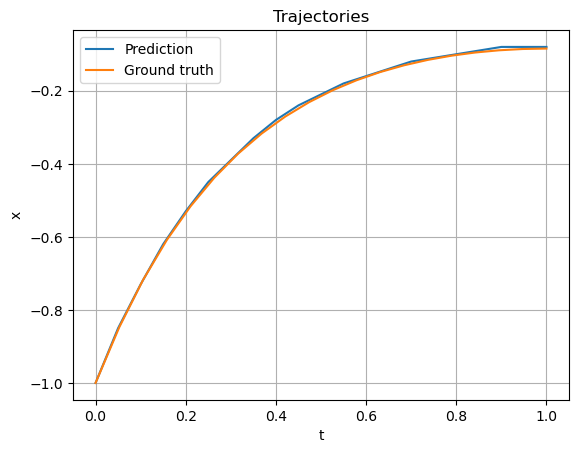

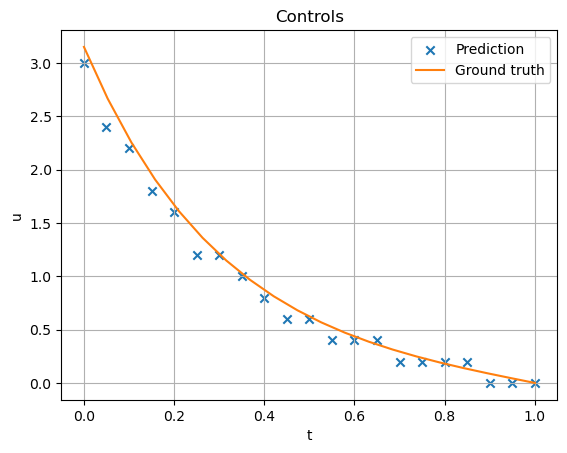

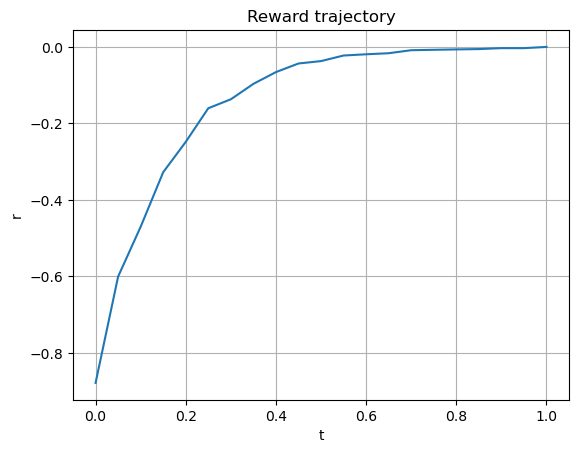

Cost for the predicted solution: 3.014562
Optimal cost: 3.021006675768451


In [437]:
test_policy(optimal_policy)

As expected, we get very good results; actually, as good results as we can get with this discretization. We also notice that the score obtained previously with $\varepsilon=0.8$ was optimal for the discretized problem.

## Transfer learning